# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно ***построить модель для задачи классификации, которая выберет подходящий тариф.*** Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 
<br>Известно:
<br>сalls — количество звонков,
<br>minutes — суммарная длительность звонков в минутах,
<br>messages — количество sms-сообщений,
<br>mb_used — израсходованный интернет-трафик в Мб,
<br>is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Открытие и изучение файла

In [1]:
#загрузка библиотек
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score 
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
calls = pd.read_csv('/datasets/users_behavior.csv') #путь к файлам

In [3]:
calls.head(7) #чтение df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1


In [4]:
calls.info() #проверка типов данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


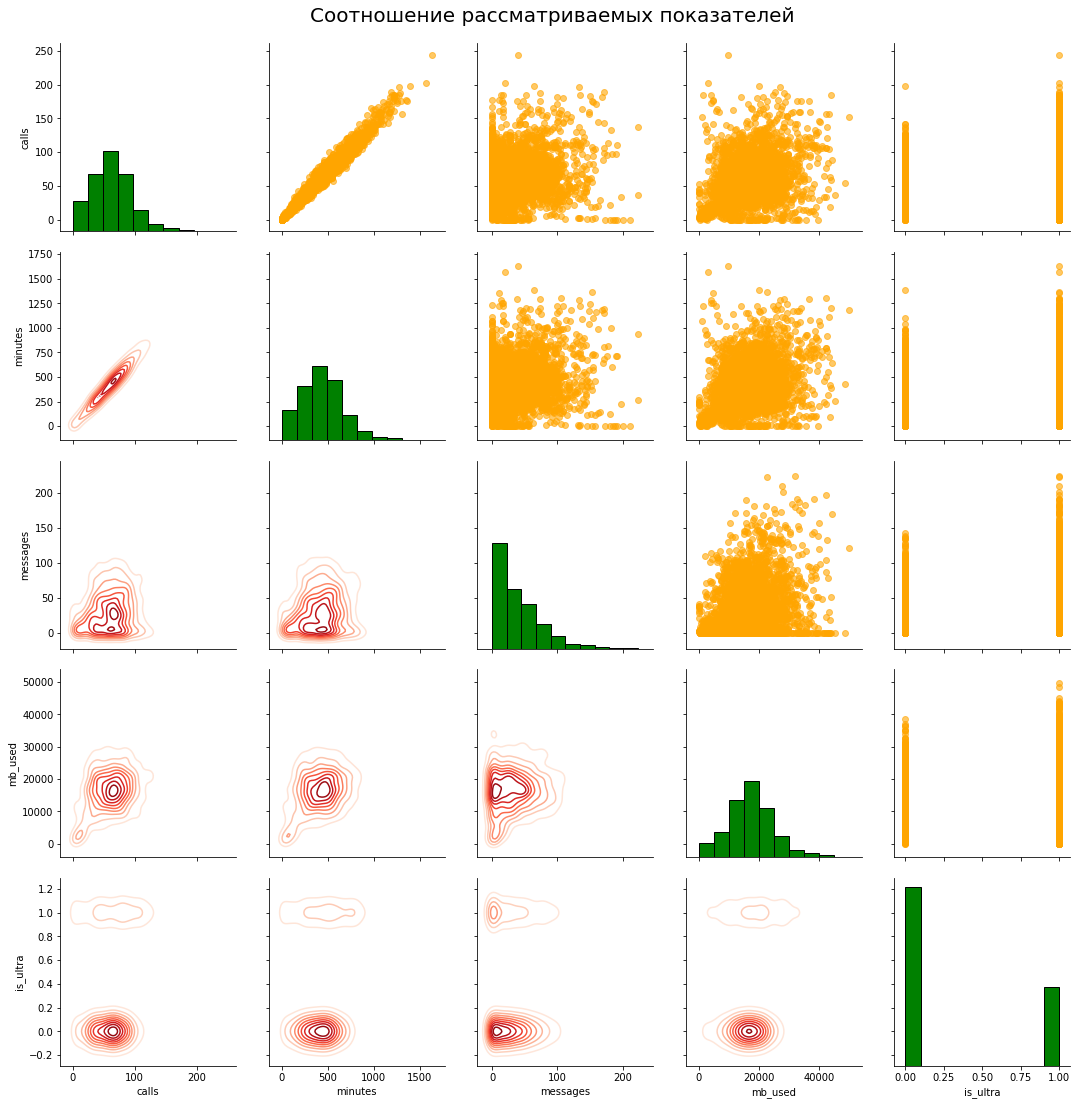

In [5]:
#Гистограмма датафрейма
grid = sns.PairGrid(data = calls, size = 3)
grid.map_upper(plt.scatter, color = 'orange', alpha = 0.6)
grid.map_diag(plt.hist, color = 'green', edgecolor = 'black')
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)
plt.suptitle('Соотношение рассматриваемых показателей', size = 20, y = 1.02);

### Вывод: 
Выборка сохранена и проверена на предмет пропусков и типа данных, для ML является корректной.

## Разделение данных на выборки

<br>Разделение исходных данные на обучающую, валидационную и тестовую выборки.
<br>Размеры тестового и валидационного наборов равны. 
<br>Исходные данные разбивают в соотношении 3:1:1.

In [6]:
# Отделение 20% данных для валидационной и тестовой выборок, обучающей 60%
features = calls.drop(['is_ultra'], axis=1) #признаки
target = calls['is_ultra'] #целевой признак

(calls.sample(frac=1, random_state=42))
train, valid, test = \
              np.split(calls.sample(frac=1, random_state=42), 
                       [int(.6*len(calls)), int(.8*len(calls))])

In [7]:
# Параметры выборок для обучения-валидации-теста
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target)

In [8]:
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train)

In [9]:
# Проверка на корректность разбиения выборок train, valid, test (60%-20%-20%)

#train.head()
#valid.head()
#test.head()

train.shape, valid.shape, test.shape

((1928, 5), (643, 5), (643, 5))

### Вывод:
<br>3 выборки (3:1:1) для обучения подготовлены, выделены признаки в тч целевой 'is_ultra', проверены на количество в соответствии с разбивкой.

## Исследование модели

Исследуем качество разных моделей, меняя гиперпараметры.
<br>Возмем для исследования 3 модели: RandomForestClassifier, LinearDiscriminantAnalysis и GradientBoostingClassifier.
<br>RandomForestClassifier- наиболее точная, LinearDiscriminantAnalysis - очень быстрая, GradientBoostingClassifier- модель хорошо учится на ошибках предыдущей.
<br>В качестве метрики использовано accuracy (доля правильных ответов алгоритма).
<br>Сравнение моделей c установлением гиперпараметров в них и их подбором с помощью GridSearchCV, обучаем модель на тренировочной выборке, проверяем на валидационной факт переобучения, как итог проверка обучившейся модели на тестовой выборке.

In [10]:
clf = RandomForestClassifier()

#Создание модели GridSearchCV с аргументами
parametrs = { 'n_estimators': range (1, 31, 10),                
              'max_depth': range (1,11),
              'max_features': range (2,5)}
grid = GridSearchCV(clf, parametrs, cv=5)
#Обучение модель на тренировочном наборе данных
grid.fit(features_train, target_train)
#Параметры лучшей модели с помощью атрибута best_params_
grid.best_params_

{'max_depth': 9, 'max_features': 3, 'n_estimators': 21}

In [42]:
#RandomForestClassifier

model_RF = RandomForestClassifier(random_state=12345, n_estimators=21, max_depth=9, max_features=3)
# инициализация модели RandomForestClassifier с параметрами random_state=12345, n_estimators=est и max_depth=depth
model_RF.fit(features_train, target_train) # обучение модели на тренировочной выборке

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [43]:
predictions_valid = model_RF.predict(features_valid) # получение предсказания модели на валидационной выборке

In [44]:
model_RF.score(features_train, target_train)

0.8937465412285556

In [45]:
model_RF.score(features_valid, target_valid)

0.8072139303482587

In [46]:
result_RF_valid = model_RF.score(features_valid, target_valid)

### Вывод:

Оптимальные параметры для обучения модели RandomForestClassifier {'max_depth': 9, 'max_features': 3, 'n_estimators': 21}.
<br>accuracy валидационной выборки 80.72%.

In [47]:
#LinearDiscriminantAnalysis

model_LDA = LDA() # инициализация модели LinearDiscriminantAnalysis
model_LDA.fit(features_train, target_train) # обучение модели на тренировочной выборке
predictions_valid = model_LDA.predict(features_valid) # получение предсказания модели на валидационной выборке
result_LDA_valid = model_LDA.score(features_valid, target_valid) 
# расчет значение метрики accuracy на валидационной выборке

predictions_train = model_LDA.predict(features_train)
result_LDA_train = model_LDA.score(features_train, target_train)        
    
print("Значение accuracy на валидационной выборке: %0.4f" % result_LDA_valid)
#print("Значение accuracy на обучающей выборке: %0.4f" % result_LDA_train)       

Значение accuracy на валидационной выборке: 0.7475


### Вывод:

Модель LinearDiscriminantAnalysis показала наименьшую точность при своей быстрой реализации- accuracy валидационной выборки 74.75%

In [17]:
clf = GradientBoostingClassifier()

parametrs = { 'n_estimators': range (1, 31, 10),
              'max_depth': range (1,11),
              'max_features': range (2,5)}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 7, 'max_features': 2, 'n_estimators': 21}

In [48]:
#GradientBoostingClassifier

model_GB = GradientBoostingClassifier(random_state=12345, n_estimators=21, max_depth=7, max_features=2)
# инициализиация модели GradientBoostingRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
model_GB.fit(features_train, target_train) # обучение модели на тренировочной выборке

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=21,
                           n_iter_no_change=None, presort='auto',
                           random_state=12345, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [49]:
predictions_valid = model_GB.predict(features_valid) # получение предсказания модели на валидационной выборке

In [50]:
model_GB.score(features_train, target_train)

0.8992805755395683

In [51]:
model_GB.score(features_valid, target_valid) 

0.7985074626865671

In [52]:
result_GB_valid = model_GB.score(features_valid, target_valid)

### Вывод:
Оптимальные параметры для обучения модели: {'max_depth': 7, 'max_features': 2, 'n_estimators': 21}
<br>accuracy валидационной выборки 79.85%.

In [53]:
accuracy_valid = pd.DataFrame([[result_RF_valid], [result_LDA_valid], [result_GB_valid]],
                           columns = ['accuracy_valid_upper_0.75'],
                           index = ['RandomForestClassifier', 'LinearDiscriminantAnalysis', 'GradientBoostingClassifier'])
accuracy_valid

,accuracy_valid_upper_0.75
RandomForestClassifier,0.807214
LinearDiscriminantAnalysis,0.747512
GradientBoostingClassifier,0.798507


RandomForestClassifier ожидаемое в лидерах при accuracy на валидации- 80.72%.

## Проверка модели на тестовой выборке

<br>Проверяем качество модели на тестовой выборке.
<br>Доля правильных ответов на тестовой выборке - accuracy свыше 0.75. 

In [54]:
#Обучение модели RandomForestClassifier

best_model_RF = RandomForestClassifier(random_state=12345, n_estimators=21, max_depth=9, max_features=3)    
best_model_RF.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [55]:
#Тестирование модели RandomForestClassifier
prediction_best_model_RF_test = best_model_RF.predict(features_test)

In [56]:
model_RF.score(features_train, target_train)

0.8937465412285556

In [57]:
model_RF.score(features_test, target_test)

0.7844112769485904

In [58]:
model_RF = model_RF.score(features_test, target_test)

In [59]:
#Обучение модели LinearDiscriminantAnalysis

best_model_LDA = LDA()
best_model_LDA.fit(features_train, target_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [60]:
# Тестирование модели LinearDiscriminantAnalysis
prediction_best_model_LDA_test = best_model_LDA.predict(features_test)

In [61]:
model_LDA.score(features_train, target_train)

0.7470946319867183

In [62]:
model_LDA.score(features_test, target_test)

0.75787728026534

In [63]:
model_LDA = model_LDA.score(features_test, target_test)

In [64]:
#Обучение модели GradientBoostingClassifier

best_model_GB = GradientBoostingClassifier(random_state=12345, n_estimators=21, max_depth=7, max_features=2)
best_model_GB.fit(features_train, target_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=7,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=21,
                           n_iter_no_change=None, presort='auto',
                           random_state=12345, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [65]:
# Тестирование модели GradientBoostingClassifier
prediction_best_model_GB_test = best_model_GB.predict(features_test)

In [66]:
model_GB.score(features_train, target_train)

0.8992805755395683

In [67]:
model_GB.score(features_test, target_test)

0.7827529021558872

In [68]:
model_GB = model_GB.score(features_test, target_test)

### Вывод:
<br>Лучшая модель RandomForestClassifier и на тестовой выборке показала высокий accuracy 80.35%.

## (бонус) Проверка модели на адекватность

<br>Сравниваем RandomForestClassifie с помощью DummyClassifier- модель корректна.

In [69]:
check = pd.DataFrame([[model_RF], [model_LDA], [model_GB]],
                           columns = ['accuracy_test_upper_0.75'],
                           index = ['RandomForestClassifier', 'LinearDiscriminantAnalysis', 'GradientBoostingClassifier'])
check

,accuracy_test_upper_0.75
RandomForestClassifier,0.784411
LinearDiscriminantAnalysis,0.757877
GradientBoostingClassifier,0.782753


In [70]:
#Метод value_counts с аргументом normalize=True показывает, что выборка несбалансирована
calls['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [71]:
x=calls['is_ultra'].value_counts(normalize=True)

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(features_train, target_train)
DummyClassifier(strategy='most_frequent')
dummy_model.predict(features_test)
x
dummy_model.score(features_train, target_train)

0.6995019369120089

### Вывод: 
<br>RandomForestClassifier показывает свое превосходство среди других моделей при обучении с установлением гиперпараметров - accuracy на валидационной выборке: 80.72%
<br>Точность лучшей модели на тесте - 78.44% выше порога обозначенного по заданию в 0.75 и также превосходит модель DummyClassifier при тесте в 0.70 - является свидетельством адвекватность выбранной модели.
<br>В модели DummyClassifier рассмотрим вариант "если просто угадать" и получаем равенство сопоставимое с долей бОльшего класса нашей несбалансированной выборки calls['is_ultra']: 0- 0.69, 1-0.31.
<br>Метод most_frequent наглядно демонстрирует: проанализировали большое количество объектов и обнаружили, что 90% содержат целевое свойство, то предположение, что каждый будущий экземпляр объекта обладает целевым свойством, дает 90% -ную вероятность правильного угадывания.